## Insights sobre os dados

Dada a base de dados das vendas, serão gerados alguns insights sobre os dados armazenados e serão comentados os comportamentos encontrados nas visualizações. O código inicial será realizado para armazenar os dados da base e criar algumas estruturas de dados a fim de facilitar o mapeamento das relações das tabelas.

In [1]:
import pyodbc
import pandas as pd
from database_information import *

conn = pyodbc.connect('Driver={'+DRIVER_NAME+'}; Server='+SERVER_NAME+', '+str(PORT)+';Database='+DATABASE_NAME+';UID='+USER+'; PWD='+PASSWORD+';')
conn.setencoding(encoding='utf-8')

# Extracting database tables to dataframes
query = "SELECT * FROM SALES.dbo.FACTOR"
factors = pd.read_sql(query, conn)
query = "SELECT * FROM SALES.dbo.CUSTOMER"
customers = pd.read_sql(query, conn)
query = "SELECT * FROM SALES.dbo.SALE"
sales = pd.read_sql(query, conn)
query = "SELECT * FROM SALES.dbo.SALECOMMENT"
salecomments = pd.read_sql(query, conn)
query = "SELECT * FROM SALES.dbo.PRODUCT"
products = pd.read_sql(query, conn)
query = "SELECT * FROM SALES.dbo.CITY"
cities = pd.read_sql(query, conn)

## Visualização de dados

As informações de interesse a serem analisadas visualmente são referentes a:
* Visualizações referente às vendas;
* Distribuição das compras ao longo das cidades (quantidade e qualidade);
* Palavras mais recorrentes nos comentários e relação dos comentários à recorrência de compras por cliente.

### Visualizações das vendas

A primeira visualização é referente a quantidade de um certo produto comprada em cada venda; o gráfico seguinte é referente à quantidade de clientes que comprou uma determinada quantidade de vezes, para analisar a fidelidade dos consumidores. Em seguida, será analisada a distribuição do valor gasto nas vendas.

Quantidade de compras x Quantidade de produtos comprados (um produto apenas)


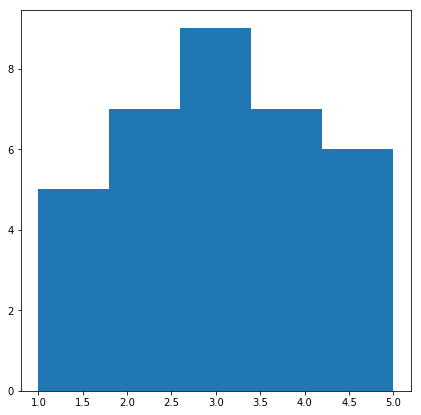

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

print('Quantidade de compras x Quantidade de produtos comprados (um produto apenas)')
sales.Amount.hist(figsize=(7,7),grid=False, bins=5)
plt.show()

Histograma de compras por cliente


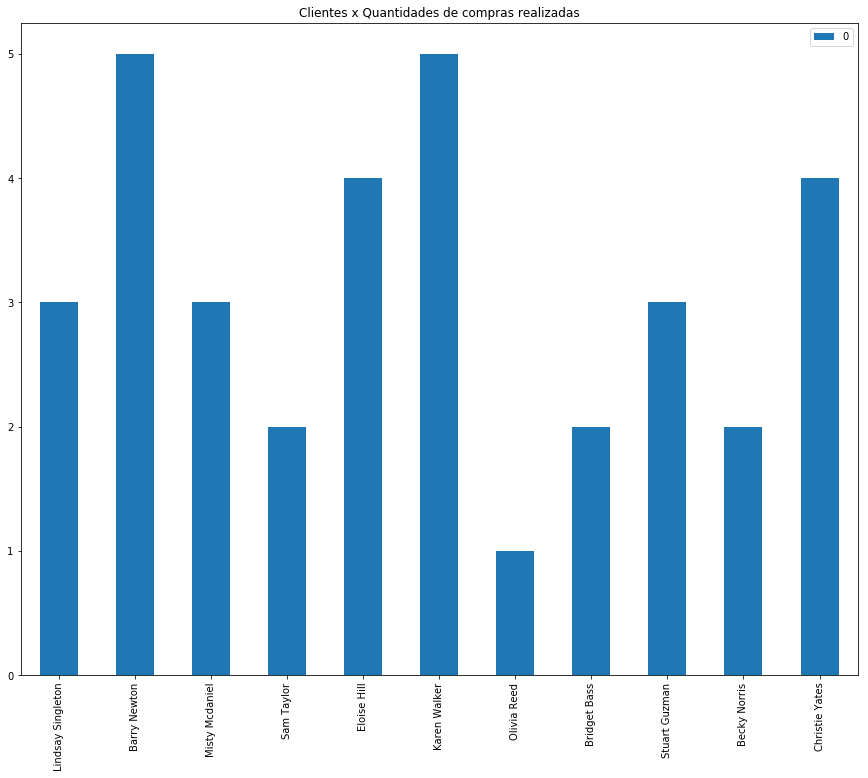

In [103]:
# Creating histogram of sales per client
customers_sales_aux = Counter(sales['CustomerId'])
customers_sales = {}

# Creating customers mapping
customer_name = np.array(customers.FirstName + ' ' + customers.LastName)
for c in customers_sales_aux:
    customers_sales[customer_name[c-1]] = customers_sales_aux[c]
del customers_sales_aux
    
df_customers = pd.DataFrame.from_dict(customers_sales, orient='index')
print('Histograma de compras por cliente')
df_customers.plot(kind='bar', title='Clientes x Quantidades de compras realizadas', figsize=[15,12])

Média de compras por cliente
2.2
Quantidade de vezes que um cliente compra, em histograma


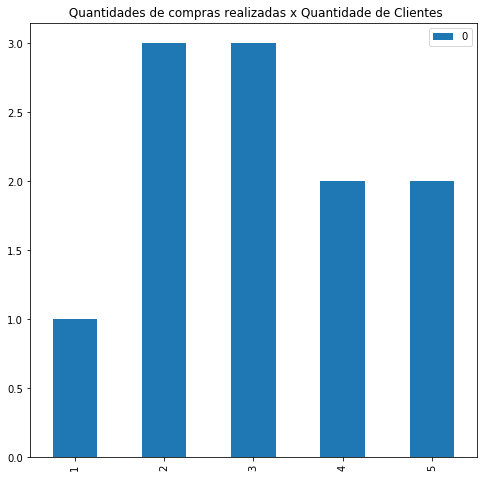

In [104]:
# Analysing how many times a client does a certain number of purchases
print('Média de compras por cliente')
print(np.mean(np.array(df_customers[0].value_counts())))

print('Quantidade de vezes que um cliente compra, em histograma')
df_customers.rename(columns={0: "sale_count"})

sales_count = df_customers[0].value_counts().to_dict()
df_sales = pd.DataFrame.from_dict(sales_count, orient='index')
df_sales.plot(kind='bar', title=' Quantidades de compras realizadas x Quantidade de Clientes', figsize=[8,8])

Histograma do valor gasto nas vendas
Valor gasto x quantidade de compras


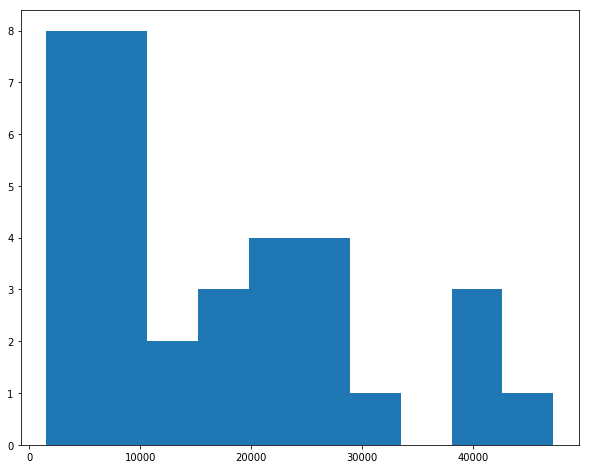

In [82]:
# Analysing how much the sales cost
# Histogram of amount spent by sale
print('Histograma do valor gasto nas vendas')
print('Valor gasto x quantidade de compras')
sales['FinalPrice'] = sales.Amount*sales.Price

sales.FinalPrice.hist(figsize=(10,8),grid=False, bins=10)
plt.show()

Média do dinheiro gasto em vendas
16604.57705882353


Boxplot do dinheiro gasto em vendas


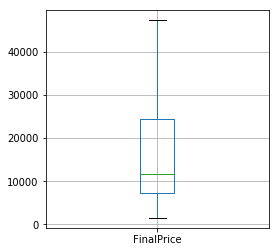

In [90]:
# Boxplot of amount spent by sale
print('Média do dinheiro gasto em vendas')
print(sales.FinalPrice.mean())

print('\n\nBoxplot do dinheiro gasto em vendas')
sales.boxplot(column=['FinalPrice'],figsize=(4,4))
plt.show()

Histograma do valor gasto por produto


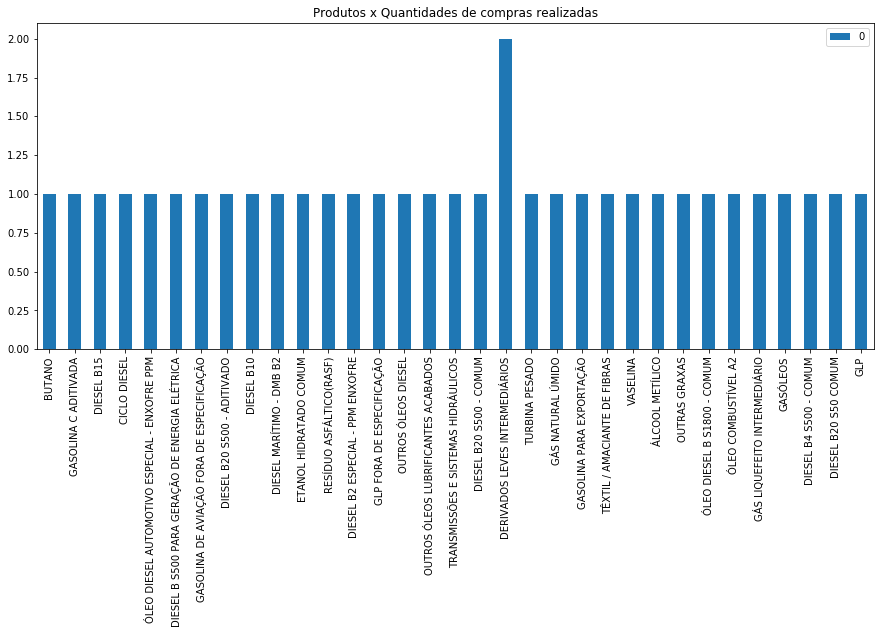

In [105]:
# Histogram of number of sales by product
product_sales_aux = Counter(sales['ProductId'])
product_sales = {}

# Creating products mapping
product_name = np.array(products.Name)
for p in product_sales_aux:    
    product_sales[product_name[p-1]] = product_sales_aux[p]
del product_sales_aux
    
df_products = pd.DataFrame.from_dict(product_sales, orient='index')
print('Histograma do valor gasto por produto')
df_products.plot(kind='bar', title='Produtos x Quantidades de compras realizadas', figsize=[15,6])

Histograma de valor gasto nas compras por produto


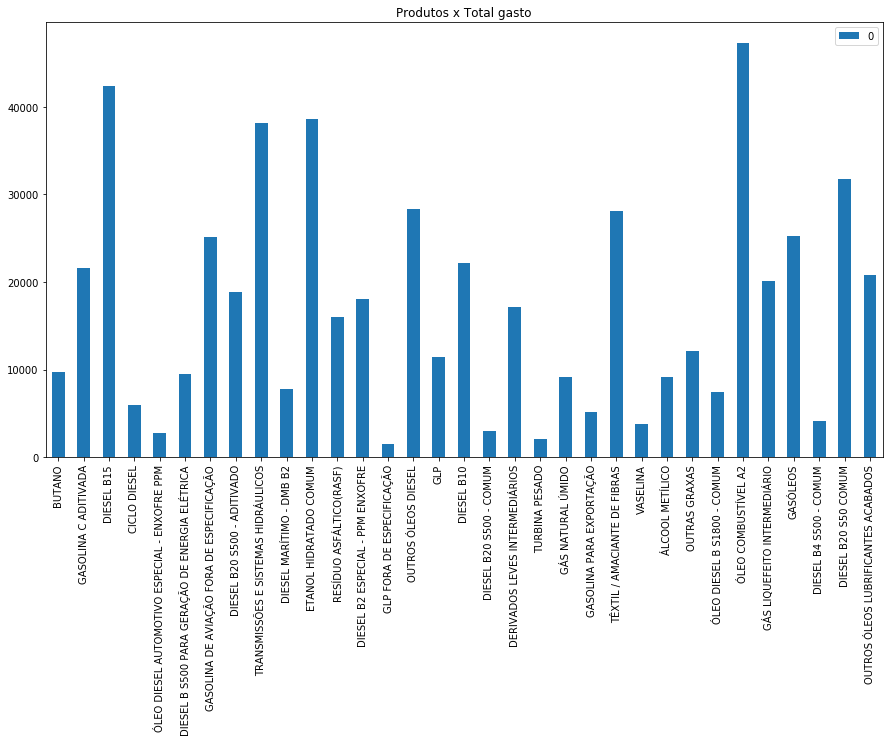

In [143]:
# Histogram of total spent by product
products_total_spent = {}
for p in df_products.index:
    query = """SELECT (S.Price*S.Amount) AS TotalSpent FROM SALES.dbo.SALE S
            INNER JOIN Product P ON P.ProductId = S.ProductId
            WHERE P.Name = '"""+p+"""'"""
    total_spent = pd.read_sql(query, conn)
    products_total_spent[p] = np.sum(np.array(total_spent.values))
    
df_total_spent_products = pd.DataFrame.from_dict(products_total_spent, orient='index')
print('Histograma de valor gasto nas compras por produto')
df_total_spent_products.plot(kind='bar', title='Produtos x Total gasto', figsize=[15,8])

Histograma de valor gasto nas compras por cliente


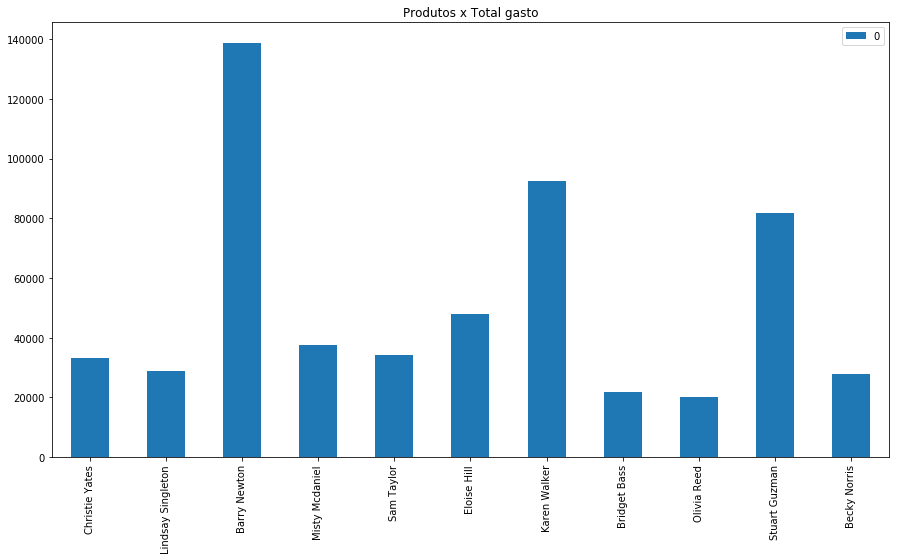

In [150]:
#Histogram of total spent by customer
customers_total_spent = {}
for c in df_customers.index:
    firstName, lastName = c.split(' ')
    query = """SELECT (S.Price*S.Amount) AS TotalSpent FROM SALES.dbo.SALE S
            INNER JOIN Customer C ON C.CustomerId = S.CustomerId
            WHERE C.FirstName = '"""+firstName+"' AND C.LastName = '"+lastName+"'"
    total_spent = pd.read_sql(query, conn)
    customers_total_spent[c] = np.sum(np.array(total_spent.values))
    
df_total_spent_customers = pd.DataFrame.from_dict(customers_total_spent, orient='index')
print('Histograma de valor gasto nas compras por cliente')
df_total_spent_customers.plot(kind='bar', title='Produtos x Total gasto', figsize=[15,8])

Pelos insights extraídos podemos observar:
* O cliente que mais gasta é o que tem o maior número de compras, porém a relação entre esses valores não é estritamente proporcional, a exemplo de Christine Yates, que realizou muitas compras, mas não está entre os maiores valores gastos por clientes. O que significa que pode não ser rentável incentivar clientes com muitas compras registradas a comprar mais, se os valores das compras são baixos. Um scatterplot poderia validar de forma melhor a inexistência de correlação, mas não foi gerada tal visualização devido ao número de amostras do dataset.
* A mesma observação vale para o total gasto nos produtos e a quantidade de compras com tal produto: não existe proporcionalidade;
* Clientes tendem a comprar, em média, 2,2 vezes, e a maioria dos clientes comprou mais de 1 vez;
* A média do total gasto por compra é, por volta dos 16000, sendo que metade dos valores estão abaixo dessa média, concentrando as vendas na casa dos 10000, como pode ser observado pelo boxplot.

### Distribuição das vendas ao longo das cidades

Análise, em gráfico de barras em relação ao total gasto nas cidades, além da quantidade total de compras.

Histograma de total de compras por cidade


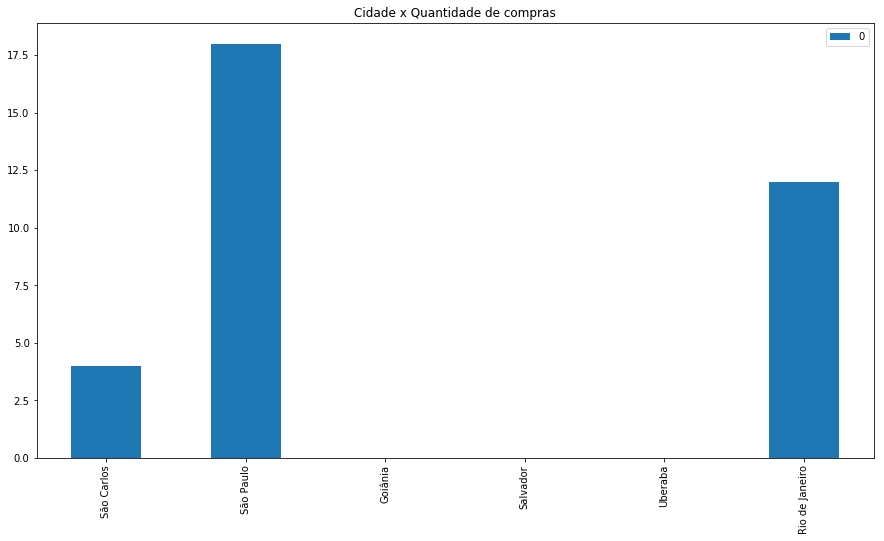

In [169]:
# Histogram of number of sales by product
#Histogram of total spent by customer
cities_total_sells = {}
for c in cities.Name:
    query = """SELECT COUNT(*) AS TotalSpent FROM SALES.dbo.SALE S
            INNER JOIN Customer C ON C.CustomerId = S.CustomerId
            INNER JOIN City Ci ON Ci.CityId = C.CityId
            WHERE Ci.Name = '"""+c+"'"
    total_spent = pd.read_sql(query, conn)
    cities_total_sells[c] = np.sum(np.array(total_spent.values))
    
df_total_cities = pd.DataFrame.from_dict(cities_total_sells, orient='index')
print('Histograma de total de compras por cidade')
df_total_cities.plot(kind='bar', title='Cidade x Quantidade de compras', figsize=[15,8])

Histograma de valor gasto nas compras por cidade


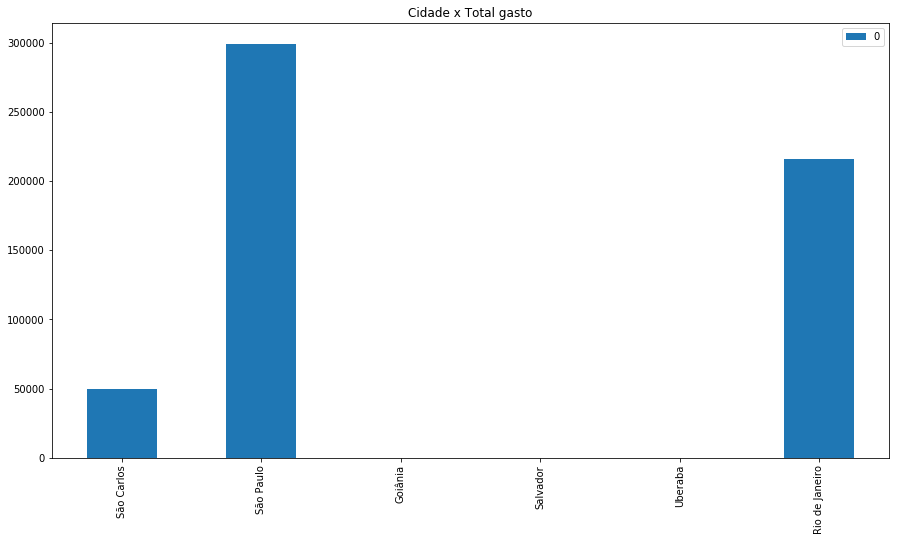

In [164]:
#Histogram of total spent by customer
cities_total_spent = {}
for c in cities.Name:
    query = """SELECT (S.Price*S.Amount) AS TotalSpent FROM SALES.dbo.SALE S
            INNER JOIN Customer C ON C.CustomerId = S.CustomerId
            INNER JOIN City Ci ON Ci.CityId = C.CityId
            WHERE Ci.Name = '"""+c+"'"
    total_spent = pd.read_sql(query, conn)
    cities_total_spent[c] = 0 if (not np.sum(np.array(total_spent.values))) else np.sum(np.array(total_spent.values))
    
df_total_spent_cities = pd.DataFrame.from_dict(cities_total_spent, orient='index')
print('Histograma de valor gasto nas compras por cidade')
df_total_spent_cities.plot(kind='bar', title='Cidade x Total gasto', figsize=[15,8])

É possível observar proporcionalidade na quantidade de compras por cidade e o total gasto nessas compras. Por esses dois histogramas, seria possível inferir, por exemplo, que São Paulo e Rio de Janeiro seriam duas cidade que gerariam bom retorno de vendas em caso de investimento em marketing e publicidade.

### Palavras mais recorrentes nos comentários e relação dos comentários à recorrência de compras por cliente

Será gerado um word cloud dos comentários. Em seguida, será feita uma análise em relação à recorrência das vendas e o comentário realizado.

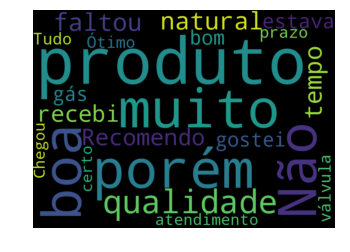

In [170]:
from wordcloud import WordCloud

words = list(salecomments.CommentText)
text = " ".join(str(x) for x in words)

# Create the wordcloud object
wordcloud = WordCloud(width=900, height=650, margin=0).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [173]:
#Analysing comments one by one since there are very few entries
salecomments

,CommentId,SaleId,CustomerId,CommentDate,CommentText
0,1,1,1,2019-08-06,A qualidade do produto é muito boa! Recomendo!
1,2,3,12,2019-11-05,"Não recebi o produto a tempo, porém estava com..."
2,3,11,56,2019-03-01,O gás natural é muito bom!
3,4,14,1,2019-10-03,Tudo certo!
4,5,17,26,2019-03-07,"Chegou no prazo, porém faltou a válvula."
5,6,27,48,2019-01-11,Não gostei.
6,7,30,12,2019-09-25,Ótimo produto e atendimento.


In [198]:
# Isolating only comments where proccess were not ok (ids 2, 5, 6)
detractor_customers = [12, 26, 48]
for c in detractor_customers:
    query = """SELECT SUM(S.Price*S.Amount) AS TotalSpent, COUNT(*) AS NumberOfSales FROM SALES.dbo.SALE S
            WHERE S.CustomerId = """+str(c)
    info = pd.read_sql(query, conn)
    print('Cliente '+str(c))
    print('Total gasto: '+str(info.TotalSpent.values))
    print('Número de compras: '+str(info.NumberOfSales.values))

Cliente 12
Total gasto: [27857.42]
Número de compras: [2]
Cliente 26
Total gasto: [81622.06]
Número de compras: [3]
Cliente 48
Total gasto: [138678.7]
Número de compras: [5]


Como o wordcloud geral foi inconclusivo, foi feito um agrupamento diferente. Outro fato que permitiu uma análise mais individual, para observar o desempenho de vendas com tais clientes. Os clientes que fizeram comentários em que ocorreu algum anormalidade, seja por não gostar do produto, seja por problemas no produto ou na entrega, no entanto, não foram impactados por isso, ou, esta foi a última compra registrada para tais clientes (dado que não há uma data atrelada à venda, mas sim, ao comentário; afinal, todos os clientes realizaram mais de uma compra. 

### Observações finais

Podemos observar, em linhas gerais, que foi possível extrair a característica geral de uma venda (preço gasto e cidade) e observar ausências e presenças de padrões em relação aos produtos vendidos e aos clientes e suas cidades.
Mesmo com uma base de dados limpa e consistente, há necessidade de alguns dados considerados faltantes, como a ausência da data de ocorrência em todas as vendas, que é extraída pelo comentário, se existente; caso houvesse melhor rastreio desse atributo seria possível fazer uma análise de churn, verificando intervalos entre data de compra e até mesmo relacionando isso ao conteúdo dos comentários, se forem enviados.